In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
import transaction_demo

In [3]:
seed = 42

### Load transactions

In [4]:
df = pd.read_csv('../data/transactions.csv')
df.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


### Clean the dataset

* Leave target columns only (date, operation and amount)
* filter out NaNs
* convert operations to int

In [5]:
df = transaction_demo.clean_dataset(df)
df.head(10)

,account_id,date,operation,amount
0,2378,1993-01-01,2,700.0
1,2378,1993-01-22,2,7268.0
2,2378,1993-01-23,2,14440.0
3,2378,1993-01-24,2,49752.0
4,2378,1993-01-26,2,21899.0
5,2378,1993-01-31,3,34700.0
7,2378,1993-02-05,2,30192.0
8,2378,1993-02-07,0,9612.0
9,2378,1993-02-11,2,31038.0
10,2378,1993-02-11,3,25200.0


Leave transaction only for the 1993 year:

In [6]:
df = df[pd.to_datetime(df['date']) < pd.to_datetime('1994-01-01')]

### Segment all transaction by month

We consider each month of an account as a separate segment. All segments are considered the same. It means our generator will generate a monthly snapshot of transactions for some user.

In [7]:
df = transaction_demo.segment_by_month(df)
df.head(10)

,date,operation,amount,day,segment_id
0,1993-01-01,2,700.0,1,2378:1993-01
1,1993-01-22,2,7268.0,22,2378:1993-01
2,1993-01-23,2,14440.0,23,2378:1993-01
3,1993-01-24,2,49752.0,24,2378:1993-01
4,1993-01-26,2,21899.0,26,2378:1993-01
5,1993-01-31,3,34700.0,31,2378:1993-01
7,1993-02-05,2,30192.0,5,2378:1993-02
8,1993-02-07,0,9612.0,7,2378:1993-02
9,1993-02-11,2,31038.0,11,2378:1993-02
10,1993-02-11,3,25200.0,11,2378:1993-02


### Prepare training data

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
transform_pipeline = Pipeline([
    ("vectorizer", transaction_demo.TransactionVectorizer(
        group_column='segment_id',
        value_column='amount',
        dim1_column='operation',
        dim2_column='day',
        dim1_size=4,
        dim2_size=32)),
    ("scale", StandardScaler(with_mean=False))
])

In [9]:
df_transformed = transform_pipeline.fit_transform(df)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_transformed, test_size=0.3, random_state=seed)

### Train the model

In [11]:
from synthesized.modules.synth import AlphaSynth
from sklearn.metrics import mean_squared_error

# define the estimator. We will use L2 penalty to augment the generalizability of the encoder
alpha = AlphaSynth(n_epochs=100, n_hidden=250, learning_rate=0.01, batch_size=106, 
                 display_step=10, activation_function='relu', verbose=2, min_change = 1e-6, 
                 random_state=seed, clip=True, l2_penalty=1e-5, 
                 early_stopping=True)

# fit
alpha.fit(X_train)

# transform and reconstruct the test images
reconstructed = alpha.feed_forward(X_test)

# get the error:
mse = ((X_test - reconstructed) ** 2).sum(axis=1).sum() / X_test.shape[0]
print("\nTest MSE: %.4f" % mse)

Epoch: 1, cost=0.743554, time=0.1407 (sec)
Convergence reached at epoch 5, stopping early
Optimization complete after 6 epoch(s). Average epoch time: 0.1713 seconds

Test MSE: 16.8777


In [12]:
# matplotlib is way too into the whole "warn for everything"
import warnings

def suppress_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper


@suppress_warnings
def showData(array_a, array_b=None, array_c=None, nrow=2, ncol=10, figsize=None, save_loc=None):
    # import without warnings
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    # if both are None, just plot one
    if array_b is None and array_c is None:
        nrow = 1
        
    # if kw specifically makes B None, shift it over
    elif array_b is None:
        array_b = array_c
        array_c = None
        nrow = 2
        
    # otherwise if just plotting the first two...
    elif array_c is None:
        nrow = 2
        
    elif array_b is not None and array_c is not None:
        nrow = 3
        
    if nrow not in (1, 2, 3):
        raise ValueError('nrow must be in (1, 2)')
        
    if figsize is None:
        figsize = (ncol, nrow)
        
    f, a = plt.subplots(nrow, ncol, figsize=figsize)
    arrays = [array_a, array_b, array_c]
    
    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')
    
    for i in range(ncol):
        if nrow > 1:
            for j in range(nrow):
                _do_show(a[j][i], np.reshape(arrays[j][i], (16, 8)))
        else:
            _do_show(a[i], np.reshape(array_a[i], (16, 8)))
            
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    f.show()
    plt.draw()
    
    # if save...
    if save_loc is not None:
        plt.savefig(save_loc)

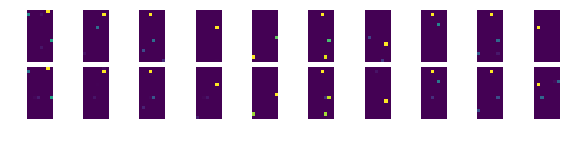

In [13]:
showData(X_test, reconstructed)

### Convert generated data to transactions

In [14]:
df_orig = transform_pipeline.inverse_transform(X_test).drop(columns=['segment_id'])

In [15]:
df_synth = transform_pipeline.inverse_transform(reconstructed).drop(columns=['segment_id'])

In [16]:
df_orig.head(10)

,operation,day,amount
0,0,6,8618.0
1,0,8,4068.0
2,0,12,446.0
3,2,15,16905.0
4,2,28,1600.0
5,3,31,14.6
6,0,14,2933.0
7,1,12,4896.0
8,3,8,350.0
9,3,31,14.6


In [17]:
df_synth.head(10)

,operation,day,amount
0,0,6,5751.06
1,0,8,2123.35
2,2,10,517.63
3,2,11,2435.04
4,2,15,11322.22
5,0,6,75.11
6,0,7,16.87
7,0,14,2834.93
8,1,12,83.99
9,2,11,814.97


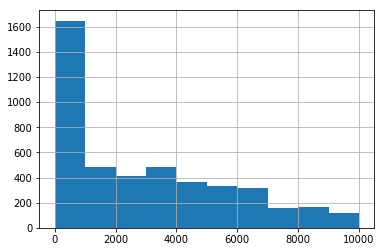

In [21]:
df_orig['amount'].hist(bins=10, range=[0,10000.0])

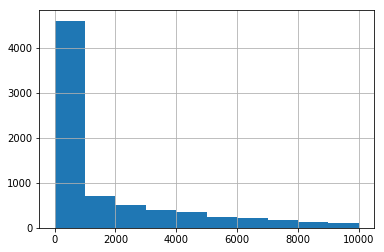

In [22]:
df_synth['amount'].hist(bins=10, range=[0,10000.0])

### Linkage attack test

In [121]:
from synthesized.testing.linkage_attack import linkage_attack, t_closeness_check

Find vulnerabilities in the original dataset:

In [122]:
vulnerabilities_orig = t_closeness_check(df_orig)

The total number of vulnerabilities:

In [123]:
len(vulnerabilities_orig)

9078

Find the remaining vulnerabilities in the synthetical data:

In [124]:
vulnerabilities_remaining = linkage_attack(df_orig, df_synth, categ_columns={'operation', 'day'}, t_closeness=0.2, k_distance=0.8)

The number of remaining vulnerabilities in synthetical data:

In [126]:
len(vulnerabilities_remaining)

898

### Percent of remaining vulnerabilities:

In [127]:
print('{:.2f}%'.format(len(vulnerabilities_remaining) / len(vulnerabilities_orig) * 100))

9.89%
